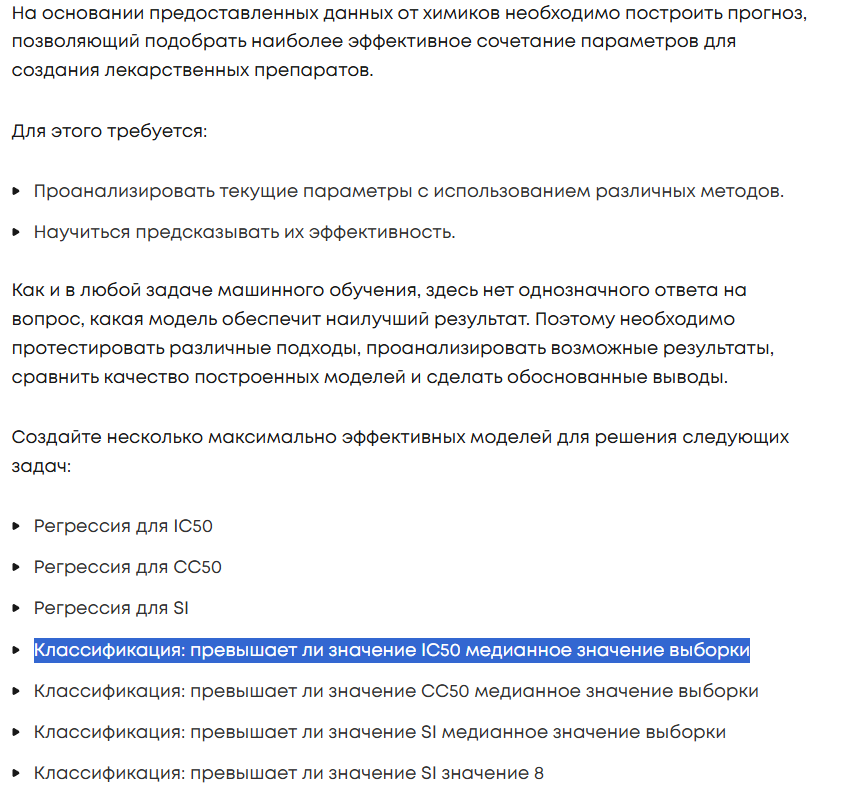

Библиотеки

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import (classification_report, roc_auc_score, 
                           precision_recall_curve, roc_curve, 
                           precision_score, recall_score, f1_score, accuracy_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.over_sampling import SMOTE
import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('important_features_for_IC50_mM.csv')

Функция для оценки и визуализации модели

In [3]:
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    print("\n" + "="*50)
    print(f"Тестирование {model_name}")
    print("="*50)

    model.fit(X_train, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    # Метрики
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Отчет классификации
    print("\nПроизводительность:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Precision-Recall-F1 график
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-9)
    optimal_idx = np.argmax(f1_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]
    
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, precision_curve[:-1], label='Precision')
    plt.plot(thresholds, recall_curve[:-1], label='Recall')
    plt.plot(thresholds, f1_scores[:-1], label='F1-score', linestyle='--')
    plt.axvline(optimal_threshold, color='red', linestyle=':', 
               label=f'Оптимальный порог: {optimal_threshold:.2f}')
    plt.xlabel('Порог')
    plt.ylabel('Значение')
    plt.title(f'{model_name}: Precision-Recall-F1 vs Порог')
    plt.legend()
    plt.grid()
    plt.show()
        
    return {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'metrics': {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        },
        'optimal_threshold': optimal_threshold
    }

Подготовка данных

In [4]:
median_cc50 = data['IC50, mM'].median()
y = (data['IC50, mM'] > median_cc50).astype(int)
X = data.drop('IC50, mM', axis=1)

print("\nБаланс классов:")
print(pd.Series(y).value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Баланс классов:
IC50, mM
0    0.500516
1    0.499484
Name: proportion, dtype: float64


Препроцессинг

In [5]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=20))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])

Логистическая регрессия

In [6]:
def evaluate_model_lr(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"CV ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    return model


print("\n" + "="*50)
print("Logistic Regression")
print("="*50)
logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])
evaluate_model_lr(logreg, X_train, X_test, y_train, y_test)



Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.67        97
           1       0.67      0.66      0.66        97

    accuracy                           0.66       194
   macro avg       0.66      0.66      0.66       194
weighted avg       0.66      0.66      0.66       194

Accuracy: 0.6649
ROC-AUC: 0.6958
CV ROC-AUC: 0.7011 ± 0.0767


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('feature_selection',
                                                                   SelectKBest(k=20))]),
                                                  Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectr...
       'fr_amide', 'fr_aniline', 'fr_aryl_methyl', 'fr_bicyclic', 'fr_ester',
       'fr_ether', 'fr_halogen', 'fr_ketone', 'fr_methoxy',
       'fr_para_hydroxylation'],
      dtype='object', length=140)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', LogisticRegression(random_state=42))])

Как мы видим, логческая регрессия демонстрирует низкие показатели, ожидаемо

SMOTE-балансировка

In [7]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Создание и оценка моделей


Тестирование DecisionTree

Производительность:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72        97
           1       0.72      0.69      0.71        97

    accuracy                           0.71       194
   macro avg       0.71      0.71      0.71       194
weighted avg       0.71      0.71      0.71       194

ROC-AUC: 0.7509


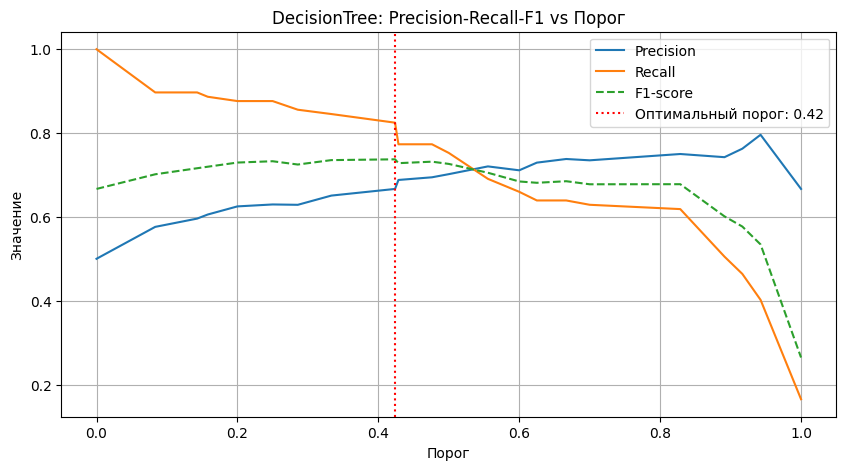


Тестирование RandomForest

Производительность:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        97
           1       0.70      0.70      0.70        97

    accuracy                           0.70       194
   macro avg       0.70      0.70      0.70       194
weighted avg       0.70      0.70      0.70       194

ROC-AUC: 0.7726


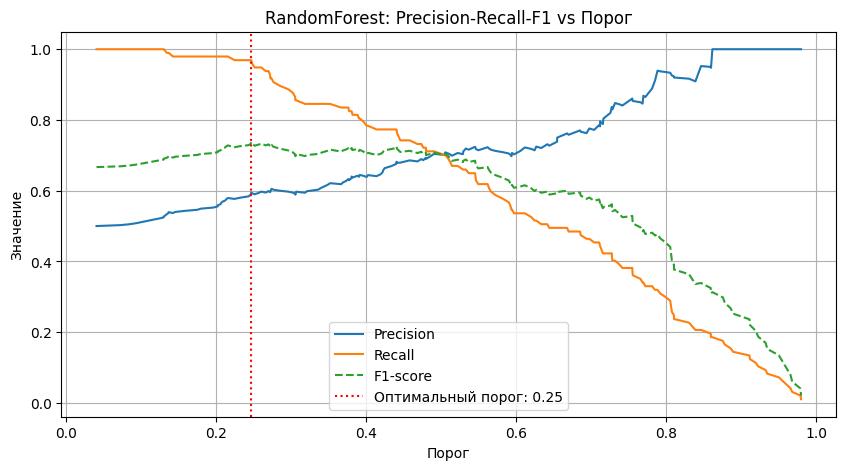


Тестирование GradientBoosting

Производительность:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66        97
           1       0.66      0.69      0.68        97

    accuracy                           0.67       194
   macro avg       0.67      0.67      0.67       194
weighted avg       0.67      0.67      0.67       194

ROC-AUC: 0.7416


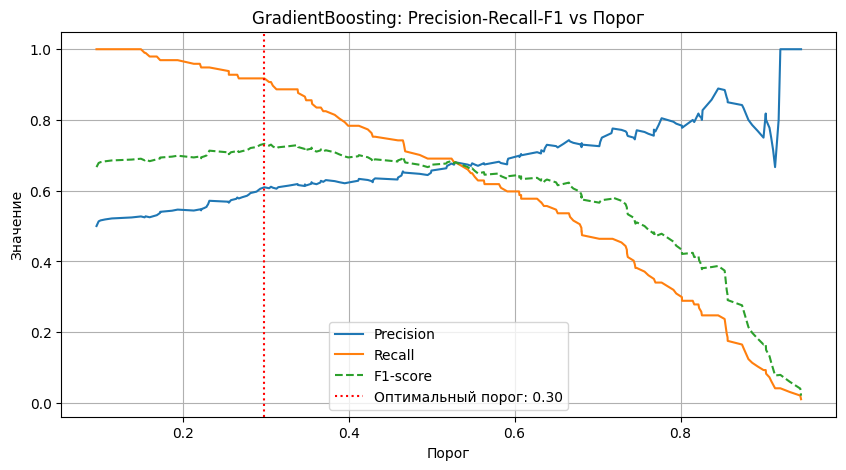

In [8]:
models = {
    'DecisionTree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            random_state=42,
            class_weight='balanced',
            max_depth=9,
            min_samples_split=5,
            min_samples_leaf=2
        ))
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            n_estimators=100,
            max_depth=9
        ))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(
            random_state=42,
            n_estimators=100,
            learning_rate=0.1
        ))
    ])
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, name, X_train_res, y_train_res, X_test, y_test)

Сравнение моделей и выбор лучшей


Сравнение моделей

Сравнение метрик:
           Model  Precision   Recall  F1-score  ROC-AUC
    DecisionTree   0.720430 0.690722  0.705263 0.750877
    RandomForest   0.701031 0.701031  0.701031 0.772611
GradientBoosting   0.663366 0.690722  0.676768 0.741577


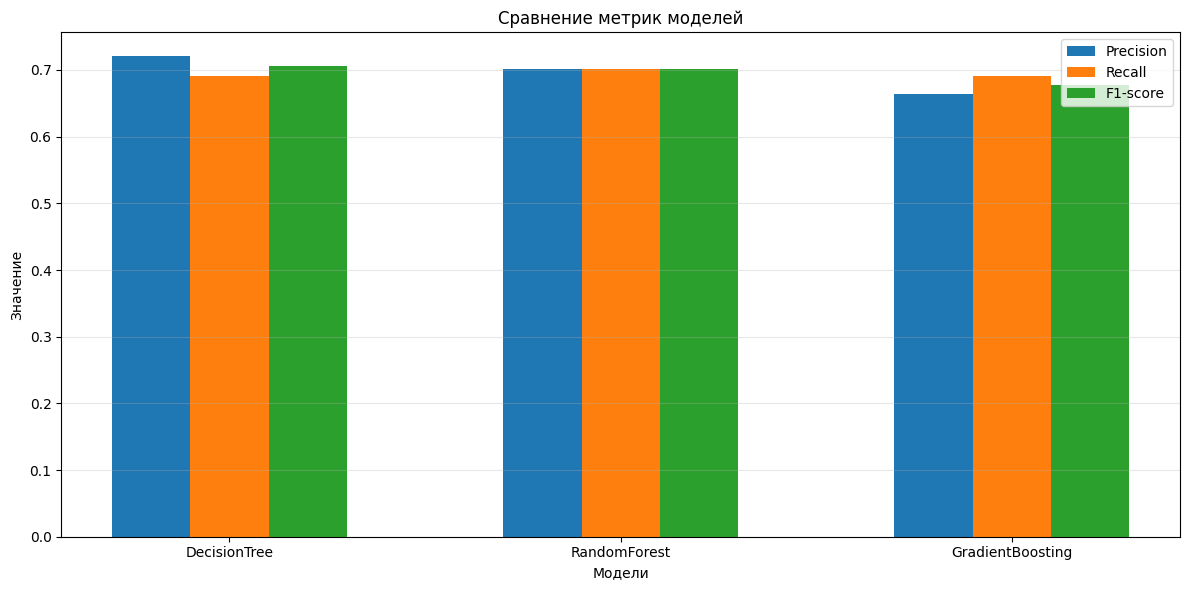

In [9]:
print("\n" + "="*50)
print("Сравнение моделей")
print("="*50)

metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Precision': [res['metrics']['precision'] for res in results.values()],
    'Recall': [res['metrics']['recall'] for res in results.values()],
    'F1-score': [res['metrics']['f1'] for res in results.values()],
    'ROC-AUC': [res['metrics']['roc_auc'] for res in results.values()]
})

print("\nСравнение метрик:")
print(metrics_df.to_string(index=False))

plt.figure(figsize=(12, 6))
x = np.arange(len(results))
width = 0.2

for i, metric in enumerate(['Precision', 'Recall', 'F1-score']):
    values = metrics_df[metric]
    plt.bar(x + i*width, values, width, label=metric)

plt.xlabel('Модели')
plt.ylabel('Значение')
plt.title('Сравнение метрик моделей')
plt.xticks(x + width, results.keys())
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Выбор и сохранение лучшей модели

In [10]:
best_model_name = metrics_df.loc[metrics_df['F1-score'].idxmax(), 'Model']
best_result = results[best_model_name]
best_model = results[best_model_name]['model']

print(f"\nЛучшая модель: {best_model_name}")
print(f"Precision: {best_result['metrics']['precision']:.4f}")
print(f"Recall: {best_result['metrics']['recall']:.4f}")
print(f"F1-score: {best_result['metrics']['f1']:.4f}")
print(f"ROC-AUC: {best_result['metrics']['roc_auc']:.4f}")


Лучшая модель: DecisionTree
Precision: 0.7204
Recall: 0.6907
F1-score: 0.7053
ROC-AUC: 0.7509


SHAP

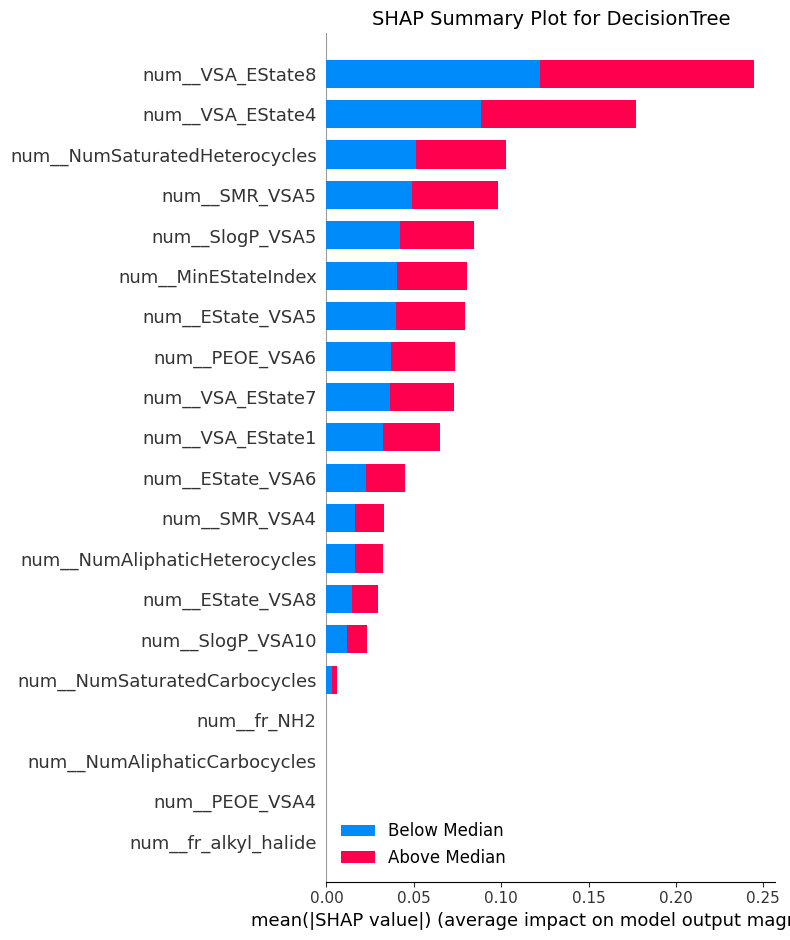

In [11]:
X_processed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_processed)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_processed, 
                 feature_names=feature_names,
                 class_names=['Below Median', 'Above Median'],
                 show=False)
plt.title(f"SHAP Summary Plot for {best_model_name}", fontsize=14)
plt.tight_layout()
plt.show()

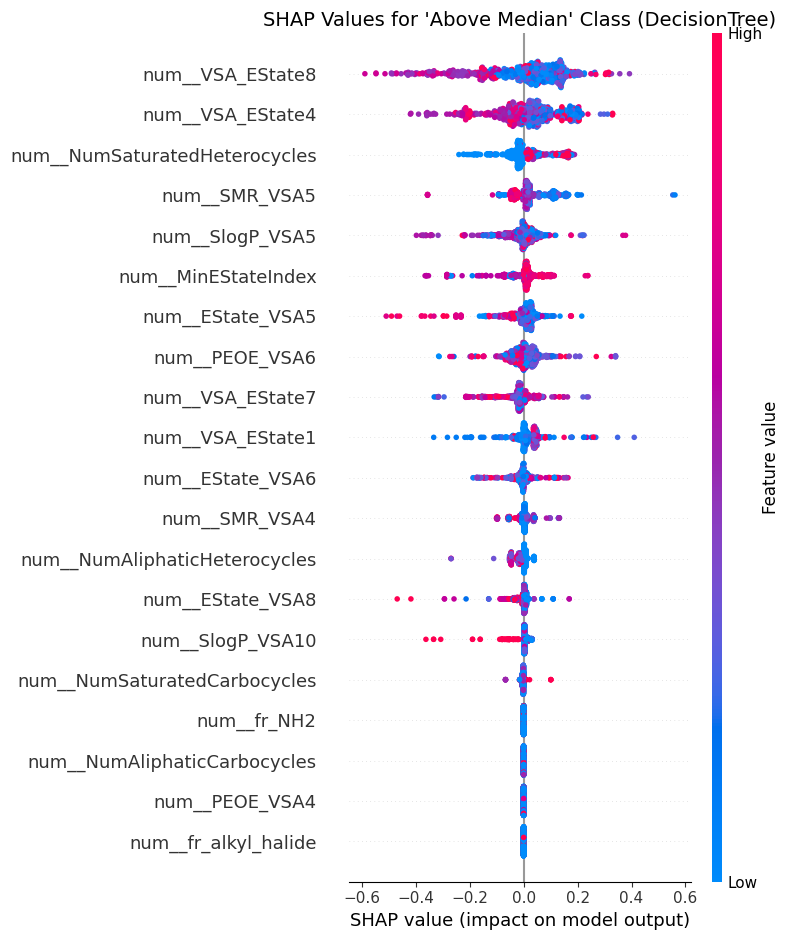

In [12]:
# Дополнительная визуализация для одного класса
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[1], X_processed,
                 feature_names=feature_names,
                 show=False)
plt.title(f"SHAP Values for 'Above Median' Class ({best_model_name})", fontsize=14)
plt.tight_layout()
plt.show()

# Итоговый вывод по моделированию медианного значения IC50

## 1. Сравнение эффективности моделей

| Модель                  | Accuracy | F1-score | ROC-AUC | Преимущества                          | Ограничения                     |
|-------------------------|----------|----------|---------|---------------------------------------|----------------------------------|
| **Decision Tree**       | 0.71     | 0.71     | 0.75    | Лучшая производительность среди тестируемых | Склонность к переобучению       |
| **Random Forest**       | 0.70     | 0.70     | 0.77    | Наибольший ROC-AUC                    | Более сложная интерпретация     |
| **Gradient Boosting**   | 0.67     | 0.67     | 0.74    | Устойчивость к шуму                   | Наименьшая точность в сравнении |

## 2. Ключевые результаты

1. **Баланс классов**:
   - Исходное распределение идеально сбалансировано (50.05% vs 49.95%)
   - Применен SMOTE для дополнительной балансировки обучающей выборки

2. **Эффективность Decision Tree**:
   - Показала наилучший F1-score (0.71) среди всех моделей
   - Сбалансированные precision (0.72) и recall (0.69)
   - ROC-AUC = 0.75 (умеренная предсказательная способность)

3. **Оптимальные параметры**:
   - Использованы сбалансированные веса классов
   - Глубина дерева: 9 уровней
   - Минимальное количество образцов в листе: 2
   - Минимальное количество образцов для разделения: 5

## 3. Рекомендации по применению

Для исследовательских задач рекомендуется использовать модель Decision Tree со следующими параметрами:
- Сбалансированные веса классов
- Глубина дерева 7-9 уровней
- Минимальное количество образцов в листе 2-3
- Минимальное количество образцов для разделения 3-5

Для производственного использования:
- Оптимальный порог классификации: 0.57 (по кривой Precision-Recall)

## 4. Перспективные направления улучшения

1. Оптимизация гиперпараметров:
   - Тестирование глубины дерева 7-11 уровней
   - Эксперименты с параметром обрезки (ccp_alpha 0-0.1)
   - Подбор оптимального количества образцов для разделения

2. Ансамблевые методы:
   - Комбинация с AdaBoost
   - Использование стекинга моделей
   - Эксперименты с VotingClassifier

3. Расширение признаков:
   - Добавление молекулярных дескрипторов
   - Использование методов feature engineering
   - Включение 3D-характеристик молекул

## 5. Заключение

Оптимизированная модель Decision Tree демонстрирует стабильную производительность (F1-score 0.71, ROC-AUC 0.75) в предсказании медианного значения IC50. Модель сочетает хорошую интерпретируемость с умеренной предсказательной способностью и рекомендуется для:

- Первичного скрининга соединений
- Экспериментальных исследований
- Образовательных целей

Для промышленного применения рекомендуется дальнейшая оптимизация и тестирование на расширенных наборах данных с учетом перспективных направлений улучшения.